# Justin Chu 
## Coursera Capstone Project: The Battle of The Neighborhoods Week 2

### A description of the problem and a discussion of the background.

A few colleagues and myself are looking to open a Crispy Creme donut shop in Suffolk County, New York.  If you live on Long Island you can relate to the continually worsening problem of a lack of donuts.  Dunkin' Donuts can only satiate the problem of having to drive the New York City for a Crispy Creme for so long before the masses crave for something more delightful. 








### A description of the data and how it will be used to solve the problem.

I will be using the Foursquare API to analyze the neighborhoods of Suffolk County to locate an area with the lowest number of venues in order to place our Crispy Creme in an area of high necessity.

Installing and importing necessary python libraries:

In [497]:
!pip install geocoder
!pip install folium

import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.neighbors import KNeighborsClassifier
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

In [498]:
# I spent my entire life on Long Island.  These popular towns came from my own knowledge:
addresses = ['Coram, New York', 'Middle Island, New York','Port Jefferson, New York', 'Patchogue, New York', 
            'Riverhead, New York', 'Central Islip, New York', 'Smithtown, New York', 'Mattituck, New York',
            'Mastic Beach, New York', 'Lake Grove, New York', 'Kings Park, New York', 'Shirley, New York', 'South Hampton, New York',
             'East Hampton, New York', 'Manorville, New York', 'Moriches, New York', 'Wading River, New York', 'West Hampton, New York',
            'Quogue, New York']
geolocator = Nominatim(user_agent='justinchu24@gmail.com')
addy_coordinates = {}
for address in addresses:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    addy_coordinates[address] = [latitude, longitude]
    print('The Geograpical Coordinates of {} are {}, {}.'.format(address, latitude, longitude))

The Geograpical Coordinates of Coram, New York are 40.87941295, -73.00394259997734.
The Geograpical Coordinates of Middle Island, New York are 40.879135, -72.94014075519021.
The Geograpical Coordinates of Port Jefferson, New York are 40.9465118, -73.0691257.
The Geograpical Coordinates of Patchogue, New York are 40.7656539, -73.0151084.
The Geograpical Coordinates of Riverhead, New York are 40.9170435, -72.6620402.
The Geograpical Coordinates of Central Islip, New York are 40.78102005, -73.19299521234569.
The Geograpical Coordinates of Smithtown, New York are 40.8559314, -73.2006687.
The Geograpical Coordinates of Mattituck, New York are 41.00715165, -72.55413708959088.
The Geograpical Coordinates of Mastic Beach, New York are 40.76078865, -72.83542008960674.
The Geograpical Coordinates of Lake Grove, New York are 40.8528761, -73.1151102.
The Geograpical Coordinates of Kings Park, New York are 40.88373, -73.2544898.
The Geograpical Coordinates of Shirley, New York are 40.79684165000000

In [499]:
#create a dataframe for the towns
df = pd.DataFrame(addy_coordinates).transpose().reset_index()
df.columns = ['Town', 'Latitude', 'Longitude']
df

,Town,Latitude,Longitude
0,"Coram, New York",40.879413,-73.003943
1,"Middle Island, New York",40.879135,-72.940141
2,"Port Jefferson, New York",40.946512,-73.069126
3,"Patchogue, New York",40.765654,-73.015108
4,"Riverhead, New York",40.917043,-72.662040
5,"Central Islip, New York",40.781020,-73.192995
6,"Smithtown, New York",40.855931,-73.200669
7,"Mattituck, New York",41.007152,-72.554137
8,"Mastic Beach, New York",40.760789,-72.835420
9,"Lake Grove, New York",40.852876,-73.115110


In [500]:
#map the towns 
li_map = folium.Map(location=[40.879135, -72.94014075519021], zoom_start=9)

for lat, lng, town in zip(df['Latitude'], df['Longitude'], df['Town']):
    
    label = '{}'.format(town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(li_map)  
    
li_map

In [501]:
# credentials for FourSquare API
radius = 10000 
LIMIT = 100
CLIENT_ID = 'IFL3GCM4TJC20R4ZPO15LTJKZX0OM2QZMGNHGC115GAWBZPN'
CLIENT_SECRET = 'XVXNQZLQFUW5B4VJBQQDLMK2LWT55XTETEEEBCGCAB03MVPZ'
VERSION = '20180604'
LIMIT = 30

In [502]:
def GetNearbyVenues(towns, latitudes, longitudes):
    venue_list = []
    for town, lat, long in zip(towns, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
       long, 
        radius, 
       LIMIT)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venue_list.append([(
            town,
            lat,
            long,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    
    return (venue_list)
                        
    


In [503]:
#Create a DataFrame from venues
li_venues = GetNearbyVenues(towns= df['Town'], latitudes= df['Latitude'], longitudes = df['Longitude'])

In [504]:
nearby_venues = pd.DataFrame([ven for venue_list in li_venues for ven in venue_list])
nearby_venues.columns = ['Town', 'TLat', 'TLong', 'Venue', 'VLat', 'VLong', 'Category']

In [505]:
nearby_venues
#274 venues 

,Town,TLat,TLong,Venue,VLat,VLong,Category
0,"Coram, New York",40.879413,-73.003943,Tequila Deli,40.882688,-73.011369,Deli / Bodega
1,"Coram, New York",40.879413,-73.003943,Popei's Clam Bar,40.869130,-73.008327,Seafood Restaurant
2,"Coram, New York",40.879413,-73.003943,Better On A Bagel,40.894961,-73.005985,Bagel Shop
3,"Coram, New York",40.879413,-73.003943,Best Market,40.869260,-73.025057,Fruit & Vegetable Store
4,"Coram, New York",40.879413,-73.003943,Texas Roadhouse,40.868288,-73.024236,Steakhouse
...,...,...,...,...,...,...,...
565,"Quogue, New York",40.823177,-72.609645,Baby Moon,40.821609,-72.641764,Italian Restaurant
566,"Quogue, New York",40.823177,-72.609645,Dockers Waterside Marina & Restaurant,40.819399,-72.563184,Seafood Restaurant
567,"Quogue, New York",40.823177,-72.609645,Shock Ice Cream and Candy Store,40.809473,-72.643375,Ice Cream Shop
568,"Quogue, New York",40.823177,-72.609645,1 North Steakhouse,40.863706,-72.556667,Steakhouse


In [506]:
# filtering venues based on category.  We only need venues that sell donuts.
nearby_venues['Category'].unique()

array(['Deli / Bodega', 'Seafood Restaurant', 'Bagel Shop',
       'Fruit & Vegetable Store', 'Steakhouse', 'Bakery', 'Café',
       'Golf Course', 'Grocery Store', 'General Entertainment',
       'Breakfast Spot', 'Asian Restaurant', 'Mexican Restaurant',
       'Pizza Place', 'Fast Food Restaurant', 'Japanese Restaurant',
       'Bar', 'Pet Store', 'Gym', 'Liquor Store', 'Chinese Restaurant',
       'Food', 'Park', 'Ice Cream Shop', 'Turkish Restaurant',
       'Coffee Shop', 'Sandwich Place', 'Diner', 'Trail',
       'American Restaurant', 'Burger Joint', 'Italian Restaurant',
       'Farm', 'Baseball Field', 'Donut Shop', 'Science Museum', 'Lounge',
       'Gift Shop', 'Brewery', 'Creperie', 'Resort', 'Candy Store',
       'Greek Restaurant', 'Tea Room', 'Dive Bar', 'Theater',
       'New American Restaurant', 'Beer Store', 'Martial Arts School',
       'Beach', 'Bistro', 'Concert Hall', 'Caribbean Restaurant', 'Pub',
       'BBQ Joint', 'Pharmacy', 'Restaurant', 'Flea Market',
   

In [507]:
filtered_columns = ['Donut Shop', 'Coffee Shop', 'Bakery', 'Dessert Shop']

In [540]:
nearby_donuts = nearby_venues.loc[nearby_venues['Category'].isin(filtered_columns)]
nearby_donuts.drop(columns=['TLat', 'TLong'], inplace=True)
nearby_donuts

,Town,Venue,VLat,VLong,Category
5,"Coram, New York",Panera Bread,40.864738,-73.049045,Bakery
29,"Coram, New York",Starbucks,40.857490,-73.080955,Coffee Shop
55,"Middle Island, New York",Dunkin',40.943870,-72.975369,Donut Shop
87,"Port Jefferson, New York",Local's,40.947989,-73.067760,Coffee Shop
96,"Patchogue, New York",Roast Coffee & Tea Trading Company,40.765763,-73.014122,Coffee Shop
104,"Patchogue, New York",Dunkin',40.774826,-73.027982,Donut Shop
112,"Patchogue, New York",Starbucks,40.777820,-73.032559,Coffee Shop
118,"Patchogue, New York",Dolci Momenti Bakery,40.792668,-73.007331,Bakery
170,"Central Islip, New York",Stanley's Bakery,40.731661,-73.187688,Bakery
183,"Smithtown, New York",Alpine Bakery,40.853676,-73.186275,Bakery


In [541]:
nearby_donuts.shape

(30, 5)

In [542]:
for lat, lng, category in zip(nearby_donuts['VLat'], nearby_donuts['VLong'], nearby_donuts['Category']):
    
    label = '{}'.format(category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(li_map) 

In [543]:
li_map
# blue points are towns, red points are near by venues that sell donuts

### Applying a machine learning technique is not necessary as my business problem is solved just by looking at the map.  Middle Island is determined to be the best location for a Crispy Creme due to no nearby venues and easy accessability from other towns.  I will apply a knn algorithm to the data just for the project demonstration.

In [544]:
town_x = df['Latitude']
town_y = df['Longitude']

donut_x = nearby_donuts['VLat']
donut_y = nearby_donuts['VLong']


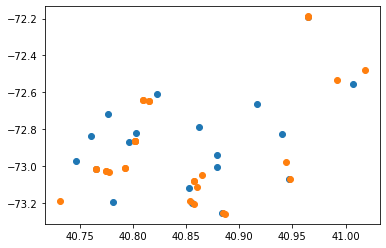

In [545]:
plt.scatter(town_x, town_y)
plt.scatter(donut_x, donut_y)
# blue points are towns, orange points are venues

In [548]:
X = list(zip(donut_x, donut_y))
y = nearby_donuts['Town']

In [550]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [552]:
yhat = classifier.predict(X_test)
yhat

array(['Mattituck, New York', 'Lake Grove, New York',
       'Patchogue, New York', 'Kings Park, New York',
       'Mattituck, New York', 'Lake Grove, New York'], dtype=object)

# Using this clustering algorithm, we can monitor new venues opening in certain areas.  